This is the tutorial for the evaluation of CPHF alchemical derivatives using PySCF (version 2.2)  

In [1]:
from pyscf import gto,scf
import numpy as np
import pyscf
pyscf.__version__

'2.2.0'

## Fractional charge molecules

In [2]:
from FcMole import FcM, FcM_like

In [3]:
mol_NN=gto.M(atom= "N 0 0 0; N 0 0 2.1",unit="Bohr", basis="sto-3g") 

The FcM_like function creates a copy of a givem PySCF molecule object with modified nuclear cherges 

In [4]:
fmol=FcM_like(mol_NN,fcs=[.1,-.1])

Only nuclear charges are modified, the number of electrons stays the same

In [5]:
fmol.atom_charges(),fmol.nelec

(array([7.1, 6.9]), (7, 7))

The same result can be achieved using the FcM constructor

In [6]:
fmol1=FcM(fcs=[.2,-.2],atom= "N 0 0 0; N 0 0 2.1",unit="Bohr", basis="sto-3g")

The number of electron matches the atom string

In [7]:
fmol1.atom_charges(),fmol1.nelec

(array([7.2, 6.8]), (7, 7))

If only some atoms have modified nuclear charges is possible to pass as a fcs parameter a double list [[idxs],[fcs]]

In [8]:
fmol2=FcM(fcs=[[0,1],[.3,-.3]],atom= "N 0 0 0; N 0 0 2.1",unit="Bohr", basis="sto-3g")

In [9]:
fmol2.atom_charges(),fmol2.nelec

(array([7.3, 6.7]), (7, 7))

For scf calculations using fractional charges molecules the initial density matrix guess needs to be evaluated from the eigenfunction of the monoelectronic Hamiltonian (there is no single atom density "SAD" matrix guess for atoms with fractional charge)

In [10]:
mf=scf.RKS(fmol)
mf1=scf.RKS(fmol1)
mf2=scf.RKS(fmol2)

In [11]:
mf.xc="PBE0"
mf1.xc="PBE0"
mf2.xc="PBE0"

In [12]:
mf.scf(dm0=mf.init_guess_by_1e())
mf1.scf(dm0=mf1.init_guess_by_1e())
mf2.scf(dm0=mf2.init_guess_by_1e())

converged SCF energy = -107.958401719176


/home/giorgio/anaconda3/lib/python3.8/site-packages/pyscf/gto/mole.py:1209: UserWarning: Function mol.dumps drops attribute with_rinv_at_nucleus because it is not JSON-serializable
  warnings.warn(msg)


converged SCF energy = -108.001857890544
converged SCF energy = -108.074269771049


-108.0742697710494

In [13]:
mf0=scf.RKS(mol_NN)
mf0.xc="PBE0"
e0=mf0.scf()
e=mf.scf(dm0=mf0.make_rdm1())
e1=mf1.scf(dm0=mf.make_rdm1())
e2=mf2.scf(dm0=mf1.make_rdm1())

converged SCF energy = -107.94391478573
converged SCF energy = -107.958401719176
converged SCF energy = -108.001857890545
converged SCF energy = -108.074269771049


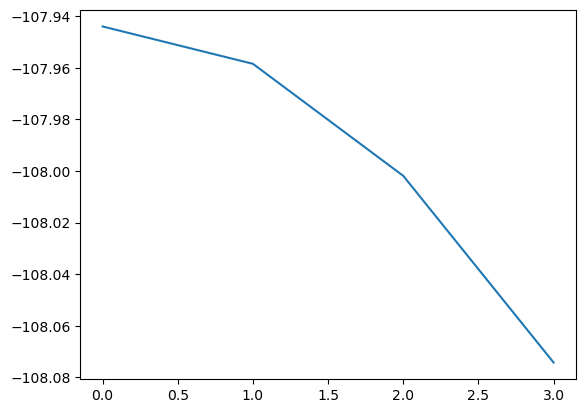

In [14]:
import matplotlib.pyplot as plt
plt.plot([e0,e,e1,e2])

## Using the Alchemical Perturbator (AP) class
We created an Alchemical perturbator object to access easily all the CPHF methods for alchemical derivative and alchemical forces derivatives, this allow us to save the derivatives and also to exploit the symmetry of the system

In [15]:
%load_ext autoreload
%autoreload 2
from AP_class import APDFT_perturbator as AP
import basis_set_exchange as bse

The alchemical perturbator is instantiated from a converged RHF object, and for some given perturbation sites.

In [39]:
mol_NN=gto.M(atom= "N 0 0 0; N 0 0 2.1",unit="Bohr", basis=bse.get_basis("pcX-1",fmt="nwchem",elements=[5,6,7,8,9])) 
mf_nn=scf.RKS(mol_NN)
mf_nn.xc="PBE0"
mf_nn.scf()
ap_nn=AP(mf_nn,sites=[0,1])

converged SCF energy = -109.373166074926


In [40]:
meth=mf_nn.__class__
meth

pyscf.dft.rks.RKS

In [41]:
meth(mol_NN),meth(mol_NN).xc

(RKS object of <class 'pyscf.dft.rks.RKS'>, 'LDA,VWN')

In [42]:
meth(mol_NN).scf()

converged SCF energy = -108.618891530152


-108.61889153015163

Alchemical gradient $ \partial E/\partial Z_i $, hessian $\partial^2E/\partial Z_i\partial Z_j$ and cubic hessian $\partial^3E/\partial Z_i\partial Z_j\partial Z_k$can be obtained from their buid functions 


In [43]:
#build the alchemical gradient dE/dZ_i
ap_nn.build_gradient()

array([-18.31728467, -18.31728467])

In [44]:
#build the alchemical hessian d**2E/dZ_i/dZ_j
ap_nn.build_hessian()

array([[-3.24373076,  0.5008886 ],
       [ 0.5008886 , -3.24373076]])

In [45]:
ap_nn.build_cubic_hessian()

array([[[-0.31206578,  0.08196272],
        [ 0.08196272,  0.08196272]],

       [[ 0.08196272,  0.08196272],
        [ 0.08196272, -0.31206578]]])

Are saved inside the class and can be accessed in a later moment

In [46]:
ap_nn.gradient,ap_nn.hessian,ap_nn.cubic_hessian

(array([-18.31728467, -18.31728467]),
 array([[-3.24373076,  0.5008886 ],
        [ 0.5008886 , -3.24373076]]),
 array([[[-0.31206578,  0.08196272],
         [ 0.08196272,  0.08196272]],
 
        [[ 0.08196272,  0.08196272],
         [ 0.08196272, -0.31206578]]]))

Alchemical perturbations for isolelectronic transmutations can be calculated from the derivatives up to order 3

In [47]:
ap_nn.APDFT1(np.asarray([-1,0])) # to CN-

-91.05588140867006

In [48]:
ap_nn.APDFT2(np.asarray([-1,1])) # to CO

-113.1177854298188

In [49]:
ap_nn.APDFT3(np.asarray([0,1]))  # to NO+

-129.36432708284795

In [50]:
ap_nn.APDFT3(np.asarray([1,1])) # to OO++

-148.7726367735566

## Alchemical forces
Alchemical forces are calculated resusing the density matrix derivatives already evaluated. The function af(i) gives the alchemical force of the atom $i$ : $\partial \mathbf{g}/ \partial Z_i$ [2]


In [51]:
ap_nn.af(0),ap_nn.af(1)

(array([[-2.59721959e-14, -2.04527881e-14, -1.73038675e-01],
        [ 2.56449983e-14,  2.26299291e-14,  1.63100615e-01]]),
 array([[-6.06753439e-14, -1.76593602e-14, -1.63100615e-01],
        [ 6.04019694e-14,  1.86166486e-14,  1.73038675e-01]]))

## Basis set effects 
The class also include methods to calculate the energy of the target molecules, with its basis set and with the basis set of the reference,

In [52]:
ap_nn.target_energy([-1,1]),ap_nn.target_energy_ref_bs([-1,1])

converged SCF energy = -113.161455102963
converged SCF energy = -113.113585054277


(-113.16145510296272, -113.11358505427737)

The APDFT3 predictions approximate the energy of the molecule with the reference basis set 

In [53]:
ap_nn.APDFT3([-1,1])

-113.11778542981817

But we can correct it using the single atom basis set correction [1]

In [54]:
ap_nn.APDFT3([-1,1])+ap_nn.ap_bsec([-1,1])

-113.1669888120743

## References 

[1] Giorgio Domenichini, Guido Falk von Rudorff, and O. Anatole von Lilienfeld : "Effects of perturbation order and basis set on alchemical predictions", J. Chem. Phys. 153, 144118 (2020)

[2] Giorgio Domenichini, and O. Anatole von Lilienfeld: "Alchemical geometry optimization", J.Chem.Phys. 156, 184801 (2022) 